This notebook generates the contact frequency plots from the preprocessed data

   [Fri Dec 18 16:22:17 2020] Plotting the sample: Mitotic AL1 []
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
   [Fri Dec 18 16:22:19 2020] Plotting the sample: Mitotic chicken (Gibcus et al, 2018) []
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encou

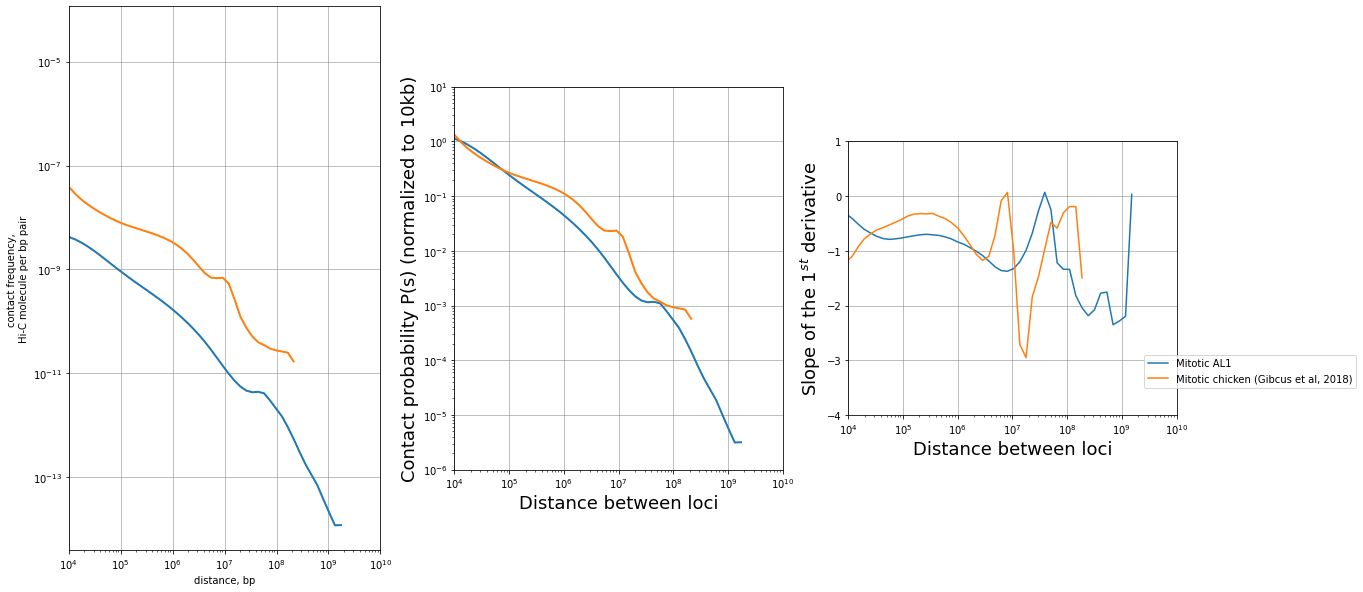

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import pairlib
import pairlib.scalings
import pairtools
import bioframe
import matplotlib.pyplot as plt
import matplotlib.gridspec
import sys
import time
import argparse
import pickle
import os
import os.path


def plotData(p_curves, p_curves_norm, p_derivatives, strSample, sc, chromosomes):
    filtered = sc.replace(-1, np.nan).dropna()
    strand_gb = filtered.query('(chrom1 == chrom2)')
    if len(chromosomes) != 0:
        arrChr = []
        for strChr in chromosomes:
            arrChr.append(f'(chrom1 == "{strChr}")')
        strQuery = " | ".join(arrChr)
        filtered = filtered.query(strQuery)
        strSample = strSample + f' ({",".join(chromosomes)})'
        print(strQuery)
    strand_gb = (filtered.query('(chrom1 != "!") & (chrom2 != "!") ').groupby(['strand1', 'strand2']))
    strand_gb = pd.concat( [ strand_gb.get_group(group) for i,group in enumerate( strand_gb.groups)] )    
    sc_agg = (strand_gb.groupby(['min_dist','max_dist']).agg({'n_pairs':'sum', 'n_bp2':'sum'}).reset_index())
    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
    mask = pair_frequencies > 0
    
    norm_freqs = pairlib.scalings.norm_scaling(dist_bin_mids, pair_frequencies, anchor=1e4)
    
    p_curves.loglog(dist_bin_mids[mask], 
                    pair_frequencies[mask], 
                    label=strSample, 
                    lw=2)
    p_curves_norm.loglog(dist_bin_mids[mask], 
                         norm_freqs[mask], 
                         label=strSample, 
                         lw=2)
    p_derivatives.semilogx(np.sqrt(dist_bin_mids.values[1:]*dist_bin_mids.values[:-1]), 
                           np.diff(np.log10(pair_frequencies.values)) / np.diff(np.log10(dist_bin_mids.values)),
                           label=strSample)



samples = [#['AL1-DpnII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.DpnII.1e1-1e11.dat'],
           ['AL1-HindIII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.HindIII.1e1-1e11.dat'],
           #['AL1-Mitotic', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.Mitotic.1e1-1e11.dat'],
           #['Human', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/Wutz_et_al/ctrl.1e1-1e11.da'],
           #['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/contact_probabilities/Chicken_30min.1e1-1e11.dat'],
           ['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/contact_probabilities/4DNFI1TM5GVZ.1e1-1e11.dat']
           ]

xmin = 1e4
xmax = 1e10

fig = plt.figure(figsize=(20,10))
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=3)
p_curves = fig.add_subplot(gs[0, 0])
p_curves_norm = fig.add_subplot(gs[0, 1])
p_derivatives = fig.add_subplot(gs[0, 2])

for i, sample in enumerate(samples):
    sc = None
    chromosomes = []
    
    strSample = sample[0]
    with open(sample[1], 'rb') as data:
        record = pickle.load(data)
        if isinstance(record, dict):
            sc = record['data']
        else:
            sc = record
        if len(sample) > 2:
            chromosomes = sample[2:]
    ts = time.asctime(time.localtime())
    
    if strSample.startswith('AL1'):
        strSample = 'Mitotic AL1'
    elif strSample.startswith('Chicken'):
        strSample = 'Mitotic chicken (Gibcus et al, 2018)'
    
    print(f"   [{ts}] Plotting the sample: {strSample} {chromosomes}", file=sys.stderr)
    plotData(p_curves, p_curves_norm, p_derivatives, strSample, sc, chromosomes)

    if i == 0:
        plt.sca(p_curves)
        plt.gca().set_aspect(1.0)
        plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.xlim([xmin, xmax])
        plt.grid(lw=0.5, color='gray')
        plt.ylabel('contact frequency, \nHi-C molecule per bp pair')
        plt.xlabel('distance, bp')
        
        plt.sca(p_curves_norm)
        plt.gca().set_aspect(1.0)
        plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.xlim([xmin, xmax])
        plt.ylim([1e-6, 1e1])
        plt.grid(lw=0.5, color='gray')
        plt.ylabel('Contact probability P(s) (normalized to 10kb)', fontsize=18)
        plt.xlabel('Distance between loci', fontsize=18)
        xt, _ = plt.xticks()
        xl = []
        for x in xt:
            if x < 1_000:
                xl.append(f'{x}')
            elif x < 1_000_000:
                xl.append(f'{x / 1_000}kb')
            elif x < 1_000_000_000:
                xl.append(f'{x / 1_000_000}Mb')
            else:
                xl.append(f'{x / 1_000_000_000}Gb')
        #plt.xticks(xt, xl, fontsize=18)

        plt.sca(p_derivatives)
        plt.gca().set_aspect(1.0)
        plt.xlim([xmin, xmax])
        plt.ylim(-4, 1)
        plt.grid(lw=0.5, color='gray')
        plt.ylabel(r'Slope of the $1^{st}$ derivative', fontsize=18)
        plt.xlabel('Distance between loci', fontsize=18)
        xt, _ = plt.xticks()
        xl = []
        for x in xt:
            if x < 1_000:
                xl.append(f'{x}')
            elif x < 1_000_000:
                xl.append(f'{x / 1_000:.0f}kb')
            elif x < 1_000_000_000:
                xl.append(f'{x / 1_000_000:.0f}Mb')
            else:
                xl.append(f'{x / 1_000_000_000:.0f}Gb')
        #plt.xticks(xt, xl, fontsize=18)
        #print(xl)
        
        xpos = plt.gca().get_xticks()
        #xlabs = list(map(lambda x: f'{x/1000}K', xpos))
        #plt.xticks(xpos, xlabs)

plt.legend(loc=(0.9,0.1))

plt.savefig('/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/figures/fig3/3c2.pdf', dpi=300)

In [6]:
print(10^4)

14


In [7]:
print(1e4)

10000.0
